## Data Preparation

In [1]:
!pip install blackjax
!pip install distrax

In [2]:
from warnings import filterwarnings

import jax
from jax import vmap, jit
import jax.numpy as jnp
from jax.random import PRNGKey, split, normal
import jax.random as random
import numpy as np

import blackjax.nuts as nuts
import blackjax.stan_warmup as stan_warmup

import distrax
import tensorflow_probability.substrates.jax.distributions as tfd

import torch
from torch.utils.data import Dataset, Subset, DataLoader, Sampler, random_split

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import confusion_matrix

import pandas as pd
import seaborn as sns

import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial

filterwarnings('ignore')
sns.set_style('white')

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

In [3]:
class MakeMoonGroupDataset(Dataset):
    def __init__(self, group, rotate_by=None, n_samples=100, noise=None, random_state=None):
        points, labels = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
        np.random.seed(random_state)
        rotate_by = np.random.randn() * 90. if rotate_by is None else rotate_by 
        self.points = self.rotate(scale(points), rotate_by)
        self.labels = labels
        self.group = group

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        point = self.points[idx]
        label = self.labels[idx]

        return point, label, self.group
    
    def rotate(self, points, deg):
      theta = np.radians(deg)
      c, s = np.cos(theta), np.sin(theta)
      R = np.array([[c, -s], [s, c]])
      rotated_points = points.dot(R)
      return rotated_points

In [4]:
class MakeMoonDataset(Dataset):
    def __init__(self, n_groups, rotations=None, n_samples=100, noise=None, random_state=None):
        np.random.seed(random_state)
        
        self.n_groups = n_groups
        if isinstance(n_samples, int):
          n_samples_per_group, leftover = divmod(n_samples, self.n_groups)
          leftover_group = np.random.randint(0, self.n_groups)
          n_samples = [n_samples_per_group] * self.n_groups
          n_samples[leftover_group] += leftover

        self.rotations = (90. * np.random.randn(n_groups,)) if rotations is None else rotations
        points, labels, groups = [], [], []

        for group, (rotate_by, N) in enumerate(zip(self.rotations, n_samples)):
            group_dataset = MakeMoonGroupDataset(group, rotate_by=rotate_by, n_samples=N, noise=noise, random_state=group)
            points.append(group_dataset.points)
            labels.append(group_dataset.labels)
            groups.append(np.ones(N,)*group)

        self.points = np.vstack(points)
        self.labels = np.concatenate(labels)
        self.groups = np.concatenate(groups)
       

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        point = self.points[idx]
        label = self.labels[idx]
        group = self.groups[idx]
        return point, label, group

In [5]:
class CustomSampler(Sampler):
    
    def __init__(self, data_source, num_of_bins, seed=0):
        self.num_samples = len(data_source)
        if isinstance(data_source, Subset):
          self.indices =  np.array(data_source.indices)
          self.groups = data_source.dataset.groups[self.indices]
          self.n_groups = data_source.dataset.n_groups
        else:
          self.indices = np.arange(self.num_samples)
          self.groups = data_source.groups
          self.n_groups = data_source.n_groups

        self.num_of_bins = num_of_bins
        self.batch_size = self.num_samples // self.num_of_bins
        np.random.seed(seed)

        
    def __iter__(self):
        preselected, remaining = [], []
      
        for group in range(self.n_groups):
          group_indices = np.argwhere(self.groups==group).flatten()
          selected_elements = np.random.choice(group_indices, size=(self.num_of_bins,), replace=False)
          preselected.append(selected_elements[..., None])
          nonselected = [i for i in group_indices if i not in set(selected_elements)]
          remaining.append(nonselected)

        preselected = np.hstack(preselected)
        perm = list(np.random.permutation(np.concatenate(remaining)))
        remaining = iter(perm)

        for i in range(self.num_samples):
          div, mod = divmod(i, self.batch_size)
         
          if div < self.num_of_bins and mod < self.n_groups:
            yield preselected[div][mod]
          else:
            yield next(remaining)
          
        
    def __len__(self):
        return self.num_samples

In [6]:
#@title Set the number of groups

n_groups = 8 #@param {type:"slider", min:0, max:20, step:1}


In [7]:
n_obs = 800
split_ratio = 0.5

#n_batches_sqr = int(np.sqrt(n_batches))

noise = 0.3
n_groups_sqr = int(np.sqrt(n_groups))
rotations = 90. * np.random.randn(n_groups + 1,)

In [8]:
rotations, new_group_deg = rotations[:-1], rotations[-1]

In [9]:
def create_datasets(n_groups, n_samples, noise=0.3, split_ratio=0.5, rotations=None):
  dataset = MakeMoonDataset(n_groups=n_groups, n_samples=n_samples, noise=noise, rotations=rotations)
  n_obs = n_samples if isinstance(n_samples, int) else (n_samples.sum() if isinstance(n_samples, np.ndarray) else sum(n_samples))
  n_train = int(n_obs * split_ratio)
  n_test =  int(n_obs - n_train)

  train_set, test_set = random_split(dataset, [n_train, n_test])
  dataloader_train = DataLoader(dataset=train_set, batch_size=n_train, num_workers=0)
  
  X_train, Y_train, groups_train = next(iter(dataloader_train))
  X_train, Y_train, groups_train = jnp.array(X_train.numpy()), jnp.array(Y_train.numpy()), jnp.array(groups_train.numpy())
  
  X_test, Y_test, groups_test = None,  None,  None
  if n_test > 0:
      dataloader_test = DataLoader(dataset=test_set, batch_size=n_test, num_workers=0)
      X_test, Y_test, groups_test = next(iter(dataloader_test))
      X_test, Y_test, groups_test = jnp.array(X_test.numpy()), jnp.array(Y_test.numpy()), jnp.array(groups_test.numpy())

  return (X_train, Y_train, groups_train), (X_test, Y_test, groups_test)
  

In [10]:
(X_train, Y_train, groups_train), (X_test, Y_test, groups_test) = create_datasets(n_groups, n_obs, noise, split_ratio, rotations)

### Create an Unseen Group

In [11]:
new_dataset = MakeMoonGroupDataset(n_groups, rotate_by=new_group_deg, n_samples=100, noise=0.3, random_state=0)
X_new, Y_new = new_dataset.points, new_dataset.labels
groups_new = jnp.ones((100, )) * n_groups
n_last = 10
(X_train_with_new_group, Y_train_with_new_group, groups_train_with_new_group), _ = create_datasets(n_groups + 1,
                                                                                                   [n_obs // (2 * n_groups)] * n_groups + [n_last] ,
                                                                                                   noise,
                                                                                                   1.0,
                                                                                                   np.append(rotations, [new_group_deg]))

In [12]:
def show_make_moon_batch(X, Y, ax=None, label=False):
    if ax is None:
      ax = plt.gca()
    ax.scatter(X[Y==0, 0], X[Y==0, 1], color='tab:blue', label='Class 0' if label else None)
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='tab:red', label='Class 1' if label else None)
    sns.despine();
    if label:
      ax.legend();

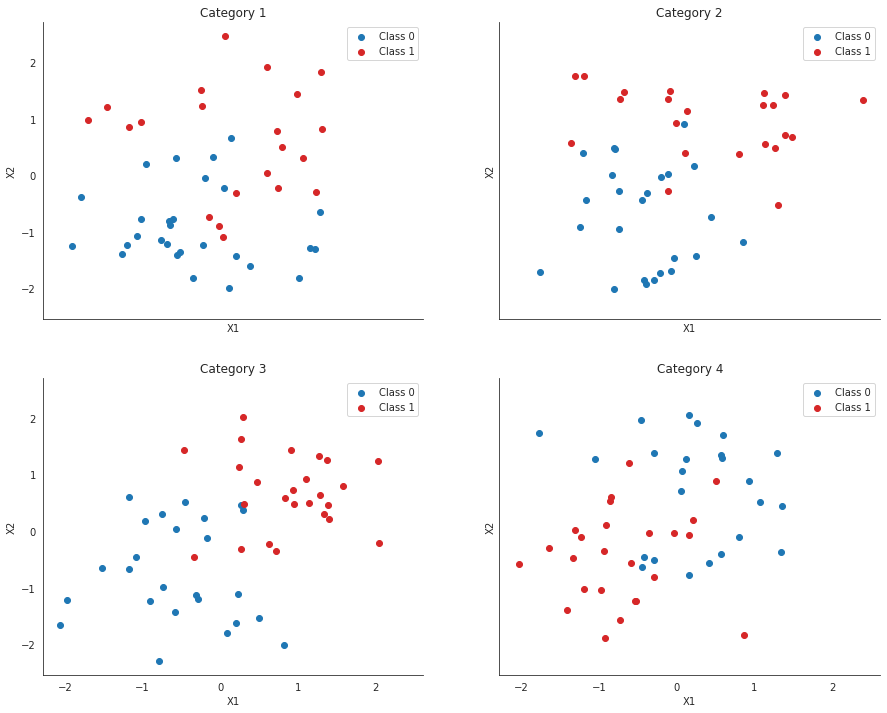

In [13]:
fig, axes = plt.subplots(figsize=(15, 12), nrows=n_groups_sqr, ncols=n_groups_sqr, sharex=True, sharey=True)
axes = axes.flatten()

for group, ax in enumerate(axes):
    indices = np.where(groups_train==group)
    X, Y = X_train[indices], Y_train[indices]
    show_make_moon_batch(X, Y, ax, True)
    ax.set(title='Category {}'.format(group + 1), xlabel='X1', ylabel='X2')

In [14]:
grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
grid_3d = jnp.repeat(grid[None, ...], n_groups, axis=0)

## Functions used for the training and test

In [15]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [16]:
#@partial(jit, static_argnames=("model", "n_hidden_layers", "num_samples", "n_groups"))
def get_predictions(model, samples, X, groups, n_hidden_layers, num_samples, rng_key, n_groups=None):
  keys = random.split(rng_key, num_samples)
  predictions = []
  if n_groups is not None:
    predictions = []
    for i, key in enumerate(keys):
        weights = []
        for j in range(n_hidden_layers + 1):
          weight = samples[f"w_{j}_mu"][i] + samples[f"w_{j}_eps"][i] * samples[f"w_{j}_std"][i]
          weights.append(weight)
        
        z = model(weights, X, groups, n_hidden_layers, n_groups)
        Y = distrax.Bernoulli(logits=z).sample(seed=key)
        predictions.append(Y[None, ...])

    return jnp.vstack(predictions)
  else:
    def sample_from_bnn(key, *weights):
      z = model(weights, X, n_hidden_layers)
      Y = distrax.Bernoulli(logits=z).sample(seed=key)
      return Y

    samples_flattened, _ = jax.tree_flatten(samples)
    predictions = vmap(sample_from_bnn)(keys, *samples_flattened)
    return predictions

In [17]:
# jit
def get_mean_predictions(predictions, threshold=0.5):
  # compute mean prediction and confidence interval around median
  mean_prediction = jnp.mean(predictions, axis=0)
  return mean_prediction > threshold

In [18]:
@partial(jit, static_argnames=("model", "potential_fn", "layer_widths", "num_warmup", "num_samples", "n_groups", "N"))
def fit_and_eval(rng_key, model, potential_fn,  layer_widths, X, Y, groups, N, num_warmup=100, num_samples=500, n_groups=None):
    init_key, warmup_key, inference_key = split(rng_key, 3)
    
    initial_position = init_bnn_params(layer_widths, init_key) if n_groups is None else init_hierarchical_params(layer_widths, n_groups, init_key)
    n_hidden_layers = len(layer_widths) - 2

    potential = partial(potential_fn, X=X, Y=Y, groups=groups, model=model, n_hidden_layers=n_hidden_layers, n_groups=n_groups, N=N)
    initial_state = nuts.new_state(initial_position, potential)
    kernel_generator = lambda step_size, inverse_mass_matrix: nuts.kernel(potential, step_size, inverse_mass_matrix)
    
    # warm up
    final_state, (step_size, inverse_mass_matrix), info = stan_warmup.run(warmup_key,kernel_generator,initial_state,num_warmup)

    nuts_kernel = jax.jit(nuts.kernel(potential, step_size, inverse_mass_matrix))
    states = inference_loop(inference_key, nuts_kernel, final_state, num_samples)
    samples = states.position

    return samples

## Hyperparameters

In [19]:
layer_widths = [2, 5, 5, 1]
n_hidden_layers = len(layer_widths) - 2

In [20]:
num_warmup = 1000 #@param {type:"slider", min:500, max:2000, step:1}

In [21]:
num_samples = 500 #@param {type:"slider", min:500, max:2000, step:1}

## Hierarchical Model

In [22]:
def init_hierarchical_params(layer_widths, n_groups, rng_key):
  half_normal = distrax.as_distribution(tfd.HalfNormal(1.0))
  rng_key, *keys = split(rng_key, len(layer_widths))
  params = {}
  for i, (n_in, n_out, key) in enumerate(zip(layer_widths[:-1], layer_widths[1:], keys)):
    mu_key, std_key, eps_key = split(key, 3)
    params[f"w_{i}_mu"] = distrax.Normal(0,1).sample(seed=mu_key, sample_shape=(n_in, n_out))
    params[f"w_{i}_std"] = half_normal.sample(seed=std_key, sample_shape=(1,))
    params[f"w_{i}_eps"] = distrax.Normal(0,1).sample(seed=eps_key, sample_shape=(n_groups, n_in, n_out))
    
  return params

In [23]:
#@partial(jit, static_argnames=("n_hidden_layers", "n_groups"))
def hierarchical_model(weights, X, groups, n_hidden_layers, n_groups):

    def forward(group, *ws):
      z = jnp.where(groups[..., None]==group, X, 0)

      for layer_idx, w in enumerate(ws):
        z = z @ w
        z = jnp.where(layer_idx==n_hidden_layers, z, jax.nn.tanh(z))
      return z
    
    z = vmap(forward)(jnp.arange(n_groups), *weights)
    z = jnp.sum(z.squeeze(-1), axis=0) 

    return z

In [24]:
#@partial(jit, static_argnames=("model", "n_hidden_layers", "n_groups", "N"))
def potential_fn_of_hierarchical_model(params, X, Y, groups,  model, n_hidden_layers, n_groups, N):
    log_joint = 0
    half_normal = distrax.as_distribution(tfd.HalfNormal(1.0))
    
    weights = []
    for i in range(n_hidden_layers + 1):
        log_joint += distrax.Normal(0., 1.0).log_prob(params[f"w_{i}_mu"]).sum()
        log_joint += half_normal.log_prob(params[f"w_{i}_std"]).sum()
        log_joint += distrax.Normal(0., 1.).log_prob(params[f"w_{i}_eps"]).sum()
        weight = params[f"w_{i}_mu"] + params[f"w_{i}_eps"] * params[f"w_{i}_std"]
        weights.append(weight)
    
    z = model(weights, X, groups, n_hidden_layers, n_groups)
    loglikelihood = distrax.Bernoulli(logits=z).log_prob(Y).sum()
    log_joint += loglikelihood
    approximation = -N * (jnp.sum(log_joint) / len(X))
    return approximation

In [25]:
def predict(model, i, samples, X, Y, groups, n_hidden_layers, rng_key, n_groups=None):
    predictions = get_predictions(model, samples, X, groups, n_hidden_layers, num_samples, rng_key, n_groups)
    Y_pred_train = get_mean_predictions(predictions)

    return jnp.mean(Y_pred_train == Y)

In [26]:
def plot_decision_surfaces_hierarchical(samples, X_train, Y_train, groups_train, grid_3d, nrows, ncols):
  fig, axes = plt.subplots(figsize=(15, 12), nrows=nrows, ncols=ncols, sharex=True, sharey=True)
  accuracy = 0
  groups = (jnp.ones((n_groups, 10000)) * jnp.arange(n_groups).reshape((-1, 1))).reshape((-1,))
  ppc_grid = get_predictions(hierarchical_model, samples, grid_3d.reshape((-1, 2)), groups, n_hidden_layers, num_samples, PRNGKey(0), n_groups=n_groups)
  
  for i, ax in enumerate(axes.flatten()):
      ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), ppc_grid.reshape((num_samples, n_groups, -1))[:, i, :].mean(axis=0).reshape(100, 100), cmap=cmap)
  
  predictions = get_predictions(hierarchical_model, samples, X_train, groups_train, n_hidden_layers, num_samples,  PRNGKey(0), n_groups)
  Y_pred_train = get_mean_predictions(predictions)
  batch_accuracy = jnp.sum(Y_train == Y_pred_train)
  
  accuracy += (batch_accuracy)
  for i, ax in enumerate(axes.flatten()):
    indices = np.where(groups_train ==i)
    X_, Y_ = X_train[indices], Y_train[indices]
    show_make_moon_batch(X_, Y_, ax, True)
  
  print(f"\nAccuracy: {accuracy/(n_obs/2.)}")

In [27]:
rng_key = PRNGKey(0)
samples = fit_and_eval(rng_key, hierarchical_model, potential_fn_of_hierarchical_model, tuple(layer_widths), X_train, Y_train, groups_train, N=len(X_train), num_warmup=num_warmup, num_samples=num_samples, n_groups=n_groups)


Accuracy: 0.9075000286102295


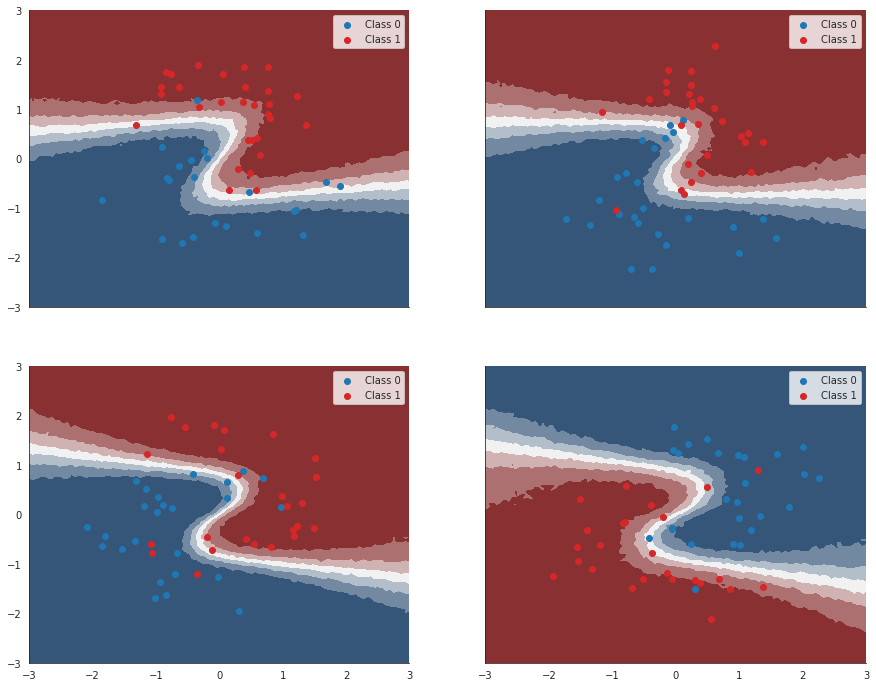

In [28]:
plot_decision_surfaces_hierarchical(samples, X_test, Y_test, groups_test, grid_3d, 2, 2)

### Confusion Matrix

In [29]:
def plot_confusion_matrix(Y_test, y_pred):
  cm = confusion_matrix(Y_test, y_pred)
  df_cm = pd.DataFrame(cm, columns=np.unique(Y_test), index = np.unique(Y_test))

  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (10,7))
  sns.set(font_scale=1.4) #for label size
  sns.heatmap(df_cm, cmap=cmap, annot=True,annot_kws={"size": 16}); # font size

In [30]:
y_pred =  get_predictions(hierarchical_model, samples, X_test, groups_test, n_hidden_layers, num_samples, PRNGKey(0), n_groups)
y_pred = get_mean_predictions(y_pred)

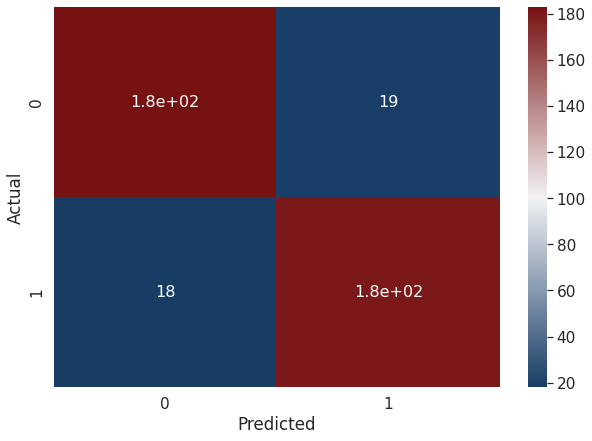

In [31]:
plot_confusion_matrix(Y_test, y_pred)

In [32]:
y_pred_new =  get_predictions(hierarchical_model, samples, X_new, groups_new, n_hidden_layers, num_samples, PRNGKey(0), n_groups)
y_pred_new = get_mean_predictions(y_pred_new)

In [33]:
print(jnp.mean(y_pred_new==Y_new))

0.52


In [34]:
grid_new = get_predictions(hierarchical_model, samples, grid, jnp.ones((len(grid),))* n_groups, n_hidden_layers, num_samples, PRNGKey(0), n_groups=n_groups)

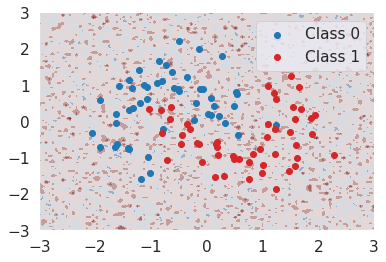

In [35]:
ax = plt.gca()
ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), grid_new.mean(axis=0).reshape(100, 100), cmap=cmap)
show_make_moon_batch(X_new, Y_new, ax, True)

In [36]:
rng_key = PRNGKey(0)
samples = fit_and_eval(rng_key,
                       hierarchical_model,
                       potential_fn_of_hierarchical_model,
                       tuple(layer_widths),
                       X_train_with_new_group,
                       Y_train_with_new_group,
                       groups_train_with_new_group,
                       N=len(X_train_with_new_group),
                       num_warmup=num_warmup,
                       num_samples=num_samples,
                       n_groups=n_groups+1)

In [37]:
y_pred_new =  get_predictions(hierarchical_model, samples, X_new, groups_new, n_hidden_layers, num_samples, PRNGKey(0), n_groups + 1)
y_pred_new = get_mean_predictions(y_pred_new)
grid_new = get_predictions(hierarchical_model,
                           samples, grid,
                           jnp.ones((10000,))* n_groups,
                           n_hidden_layers, num_samples,
                           PRNGKey(0),
                           n_groups=n_groups+1)

In [38]:
print(jnp.mean(y_pred_new==Y_new))

0.81


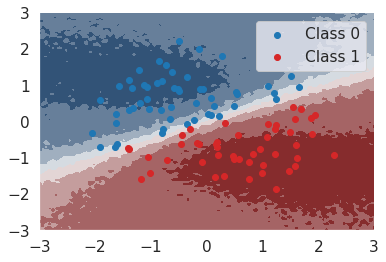

In [39]:
ax = plt.gca()
ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), grid_new.mean(axis=0).reshape(100, 100), cmap=cmap)
show_make_moon_batch(X_new, y_pred_new, ax, True)

## Separate MLPs (No Pooling)

In [40]:
def init_bnn_params(layer_widths, rng_key):
  rng_key, *keys = split(rng_key, len(layer_widths))
  params = {}
  
  for i, (n_in, n_out, key) in enumerate(zip(layer_widths[:-1], layer_widths[1:], keys)):
    params[f"w_{i}"] = distrax.Normal(0,1).sample(seed=key, sample_shape=(n_in, n_out))
  
  return params

In [41]:
def bnn(weights, X, n_hidden_layers):
    z = X
    for i, weight in enumerate(weights):
      z = z @ weight
      z = jax.nn.tanh(z) if i != n_hidden_layers else z

    z = z.squeeze(-1)
    return z

In [42]:
def potential_fn_of_bnn(params, X, Y, groups, model, n_hidden_layers, N,  n_groups=None):
    log_joint = 0

    for i in range(n_hidden_layers + 1):
        log_joint += distrax.Normal(0., 1.).log_prob(params[f"w_{i}"]).sum()
    
    weights, _ = jax.tree_flatten(params)
    z = model(weights, X, n_hidden_layers)
    loglikelihood = distrax.Bernoulli(logits=z).log_prob(Y).sum()
    log_joint += loglikelihood
 
    return -N * jnp.sum(log_joint) / len(X)

In [43]:
def fit_and_eval_separate_mlps(prng_key, layer_widths, loaders, dataset_sizes, num_warmup=100,  num_samples=500):
    mlps = []
    keys = split(prng_key, len(loaders))
    fit_fn = partial(fit_and_eval, model=bnn, potential_fn=potential_fn_of_bnn,num_warmup=num_warmup, layer_widths=layer_widths, num_samples=num_samples, n_groups=None)
    for key, loader, n_x in zip(keys, loaders, dataset_sizes):
      X_, Y_, groups_ = next(iter(loader))
      X_, Y_, groups_ = jnp.array(X_.numpy()),jnp.array(Y_.numpy()), jnp.array(groups_.numpy())
      samples = fit_fn(rng_key = key,  X=X_, Y=Y_, groups=groups_, N=n_x)
      mlps.append(samples)
    return mlps

In [44]:
train_loaders, test_loaders = [], []
dataset_sizes = [100, 120, 120, 100, 100, 100, 100, 140]

for group, n_x in enumerate(dataset_sizes):
    d = MakeMoonGroupDataset(group, noise=0.3, n_samples=n_x)
    d_train, d_test = torch.utils.data.random_split(d, [n_x//2, n_x//2])
    dl_train = DataLoader(d_train, batch_size=n_x//2, shuffle=True, num_workers=0)
    dl_test = DataLoader(d_test, batch_size=n_x//2, shuffle=True, num_workers=0)
    train_loaders.append(dl_train)
    test_loaders.append(dl_test)

In [45]:
mlps = fit_and_eval_separate_mlps(PRNGKey(0), tuple(layer_widths), train_loaders, dataset_sizes, num_warmup=num_warmup,  num_samples=num_samples)

In [46]:
rng_key= PRNGKey(0)
rng_key, *test_keys = split(rng_key, n_groups + 1)

In [47]:
for i, (samples, loader, key) in enumerate(zip(mlps, test_loaders, test_keys)):
  X_, Y_, groups_ = next(iter(loader))
  X_, Y_, groups_ = jnp.array(X_.numpy()),jnp.array(Y_.numpy()), jnp.array(groups_.numpy())
  print(f'Test Accuracy of Group {i+1} : {predict(bnn, i, samples, X_, Y_, groups_, n_hidden_layers, key, n_groups=None)}')

Test Accuracy of Group 1 : 0.7400000095367432
Test Accuracy of Group 2 : 0.8999999761581421
Test Accuracy of Group 3 : 0.8666666746139526
Test Accuracy of Group 4 : 0.8600000143051147
Test Accuracy of Group 5 : 0.8399999737739563
Test Accuracy of Group 6 : 0.9200000166893005
Test Accuracy of Group 7 : 0.9200000166893005
Test Accuracy of Group 8 : 0.8714285492897034


In [48]:
def plot_decision_surfaces_non_hierarchical(mlps, nrows, ncols, loaders):
  fig, axes = plt.subplots(figsize=(15, 12), nrows=2, ncols=2, sharex=True, sharey=True)
  accuracy = 0

  for i, (samples,ax) in enumerate(zip(mlps, axes.flatten())):
      ppc_grid = get_predictions(bnn, samples, grid, None, n_hidden_layers, num_samples, PRNGKey(0), n_groups=None)
      ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), ppc_grid.reshape((num_samples, -1)).mean(axis=0).reshape(100, 100), cmap=cmap)

    
  for j, (samples, loader) in enumerate(zip(mlps, loaders)):
    for b, batch in enumerate(loader):
      X, Y, groups = batch
      predictions = get_predictions(bnn, samples, X.numpy(), groups.numpy(), n_hidden_layers, num_samples,  PRNGKey(j), n_groups=None)
      Y_pred_train = get_mean_predictions(predictions)
      batch_accuracy = jnp.sum(Y.numpy() == Y_pred_train)
      print(f'Batch {b} - Accuracy {batch_accuracy/len(X)}', end="\n")
      accuracy += (batch_accuracy)
      for i, ax in enumerate(axes.flatten()):
        indices = np.where(groups.numpy()==i)
        X_, Y_ = X[indices], Y[indices]
        show_make_moon_batch(X_.numpy(), Y_, ax, j == 0 and b == 0)

  print(f"\nAccuracy: {accuracy/(n_obs/2.)}")

Batch 0 - Accuracy 0.8999999761581421
Batch 0 - Accuracy 0.9166666865348816
Batch 0 - Accuracy 0.8666666746139526
Batch 0 - Accuracy 0.8600000143051147
Batch 0 - Accuracy 0.8399999737739563
Batch 0 - Accuracy 0.800000011920929
Batch 0 - Accuracy 0.8999999761581421
Batch 0 - Accuracy 0.9142857193946838

Accuracy: 0.9649999737739563


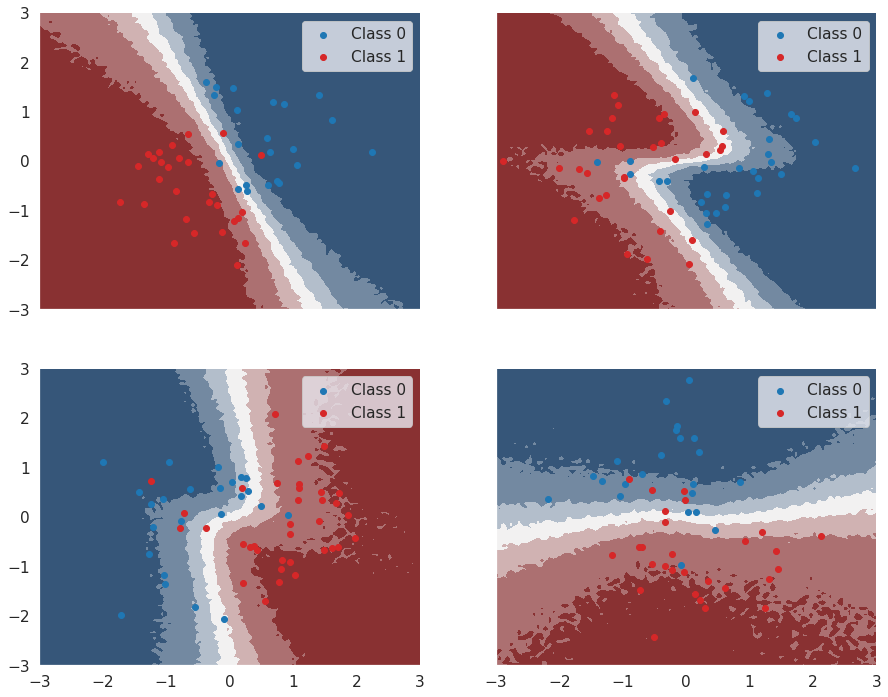

In [49]:
plot_decision_surfaces_non_hierarchical(mlps,nrows=n_groups_sqr, ncols=n_groups_sqr, loaders=train_loaders)

## Single pooled MLP

In [50]:
rng_key = PRNGKey(0)
samples = fit_and_eval(rng_key, bnn, potential_fn_of_bnn, tuple(layer_widths), X_train, Y_train, groups_train, N=len(X_train), num_warmup=num_warmup, num_samples=num_samples, n_groups=None)

In [51]:
ppc_grid = get_predictions(bnn, samples, grid, None, n_hidden_layers, num_samples, PRNGKey(0), n_groups=None)
ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), ppc_grid.reshape((num_samples, -1)).mean(axis=0).reshape(100, 100), cmap=cmap);

Accuracy 0.6175000071525574


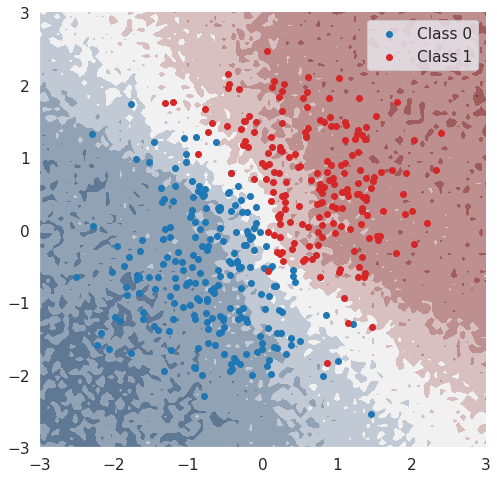

In [52]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), ppc_grid.reshape((num_samples, -1)).mean(axis=0).reshape(100, 100), cmap=cmap)
 
predictions = get_predictions(bnn, samples, X_train, groups_train, n_hidden_layers, num_samples,  PRNGKey(0), n_groups=None)
Y_pred_train = get_mean_predictions(predictions)
batch_accuracy = jnp.sum(Y_train == Y_pred_train)
print(f'Accuracy {batch_accuracy/len(X_train)}', end="\n")
show_make_moon_batch(X_train, Y_pred_train, ax, True)

### Confusion Matrix

In [53]:
y_pred =  get_predictions(bnn, samples, X_test, groups_test, n_hidden_layers, num_samples, PRNGKey(0), None)
y_pred = get_mean_predictions(y_pred)

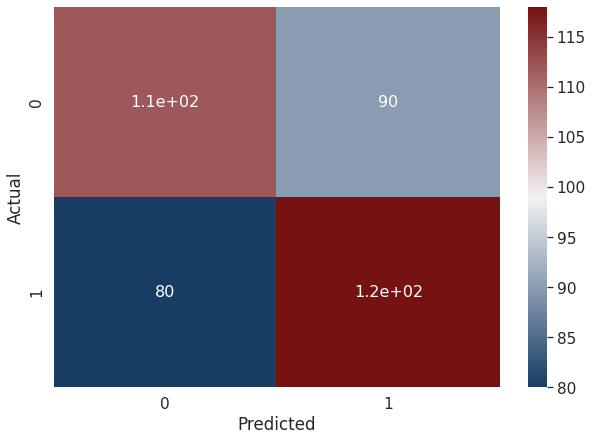

In [54]:
plot_confusion_matrix(Y_test, y_pred)

In [55]:
y_pred_new =  get_predictions(bnn, samples, X_new, groups_new, n_hidden_layers, num_samples, PRNGKey(0), None)
y_pred_new = get_mean_predictions(y_pred_new)

In [56]:
print(jnp.mean(y_pred_new==Y_new))

0.5


In [57]:
grid_new = get_predictions(bnn, samples, grid, jnp.ones((10000,))* n_groups, n_hidden_layers, num_samples, PRNGKey(0), n_groups=None)

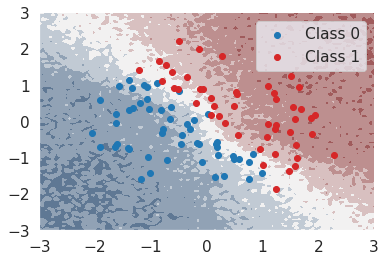

In [58]:
ax = plt.gca()
ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), grid_new.mean(axis=0).reshape(100, 100), cmap=cmap)
show_make_moon_batch(X_new, y_pred_new, ax, True)

In [59]:
rng_key = PRNGKey(0)
samples = fit_and_eval(rng_key,
                       bnn,
                       potential_fn_of_bnn,
                       tuple(layer_widths),
                       X_train_with_new_group,
                       Y_train_with_new_group,
                       groups_train_with_new_group,
                       N=len(X_train_with_new_group),
                       num_warmup=num_warmup,
                       num_samples=num_samples,
                       n_groups=None)

In [60]:
y_pred_new =  get_predictions(bnn, samples, X_new, groups_new, n_hidden_layers, num_samples, PRNGKey(0), None)
y_pred_new = get_mean_predictions(y_pred_new)
grid_new = get_predictions(bnn,
                           samples, grid,
                           jnp.ones((10000,))* n_groups,
                           n_hidden_layers, num_samples,
                           PRNGKey(0),
                           n_groups=None)

In [61]:
print(jnp.mean(y_pred_new==Y_new))

0.52


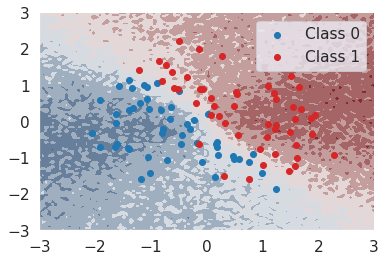

In [62]:
ax = plt.gca()
ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), grid_new.mean(axis=0).reshape(100, 100), cmap=cmap)
show_make_moon_batch(X_new, y_pred_new, ax, True)